# Reinforcement Learning

# 3. Online evaluation

This notebook presents the online evaluation of a policy by **Monte-Carlo learning** and **TD learning**.

In [1]:
import numpy as np

In [45]:
from model import Maze, Walk, TicTacToe, Nim, ConnectFour
from agent import Agent, OnlineEvaluation
from dynamic import PolicyEvaluation

## To do

* Complete the class ``MCLearning`` and test it on the random walk.
* Compare with the exact solution obtained by Dynamic Programming.<br> You might plot the [Spearman's correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between both value functions with respect to the training time.
* Do the same with ``TDLearning``.

## Monte-Carlo learning

In [77]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""
        
    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            # to be modified
            # begin
            try:
                next_reward
            except NameError:
                next_reward = 0
            gain = next_reward + self.gamma * gain
            next_reward = reward
            # end 
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count
            

## TD learning

In [14]:
class TDLearning(OnlineEvaluation):
    """Online evaluation by TD learning."""
        
    def update_values(self, state=None, horizon=100):
        """Update values online from one episode."""
        self.model.reset(state)
        for t in range(horizon):
            state = self.model.state
            # to be completed
            code = self.model.encode(state)
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            next_state = self.model.state
            next_code = self.model.encode(next_state)
            self.count[code] += 1
            gain = reward + self.gamma * self.value[next_code]
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count
            if stop:
                break
            


## Walk

In [64]:
walk = Walk()

---
#### Monte Carlo

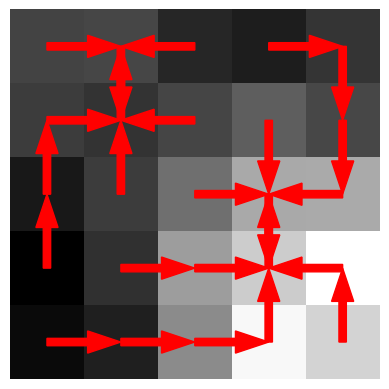

In [101]:
algo_MC = MCLearning(walk, policy='random', gamma=0.9)
n_episodes = 1000
valuelist_MC = []
for t in range(n_episodes):
    algo_MC.update_values()
    valuelist_MC.append(algo_MC.get_values().copy())
values_MC = algo_MC.get_values()
policy_MC = algo_MC.get_policy()
walk.display_policy(policy_MC)
walk.display_values(values_MC)

---

#### Temporal Difference

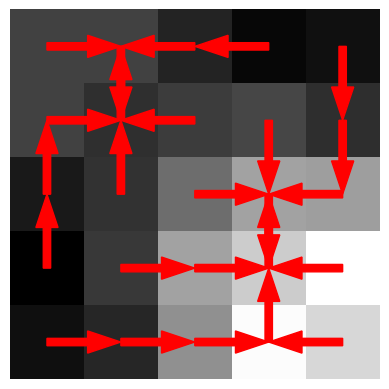

In [102]:
algo_TD = TDLearning(walk, policy='random', gamma=0.9)
n_episodes = 1000
valuelist_TD = []
for t in range(n_episodes):
    algo_TD.update_values()
    valuelist_TD.append(algo_TD.get_values().copy())
values_TD = algo_TD.get_values()
policy_TD = algo_TD.get_policy()
walk.display_policy(policy_TD)
walk.display_values(values_TD)

---
#### Dynamic Programming

In [103]:
class ValueIteration(PolicyEvaluation):
    def __init__(self, model, player=None, gamma=1, n_iter=100):
        agent = Agent(model, player=player)
        policy = agent.policy
        player = agent.player
        super(ValueIteration, self).__init__(model, policy, player, gamma)  
        self.n_iter = n_iter
        
    def get_optimal_policy(self):
        values = np.zeros(self.n_states)
        valuelist_DP = []
        for t in range(self.n_iter):
            next_values = self.rewards + self.gamma * values
            action_value = {action: transition.dot(next_values) for action, transition in self.transitions.items()}
            values = np.zeros(self.n_states)
            for i, state in enumerate(self.states):
                if not self.model.is_terminal(state):
                    actions = self.get_actions(state)
                    values[i] = max([action_value[action][i] for action in actions])
            valuelist_DP.append(values.copy())
        self.values = values
        policy = self.get_policy()
        return policy, valuelist_DP

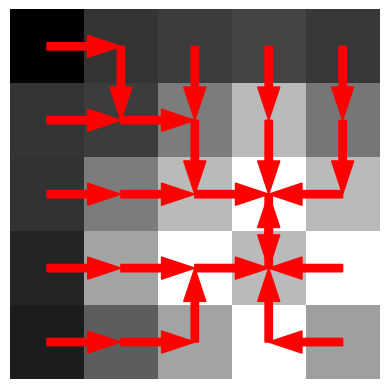

In [106]:
algo_DP = ValueIteration(walk, gamma=0.9, n_iter=n_episodes)
policy_DP, valuelist_DP = algo_DP.get_optimal_policy()
values_DP = algo_DP.values
walk.display_policy(policy_DP)
walk.display_values(values_DP)

We can find that both the MC and TD learning can get similar results to DP, but there're still some differences between final values.

---

#### Spearman's Correlation

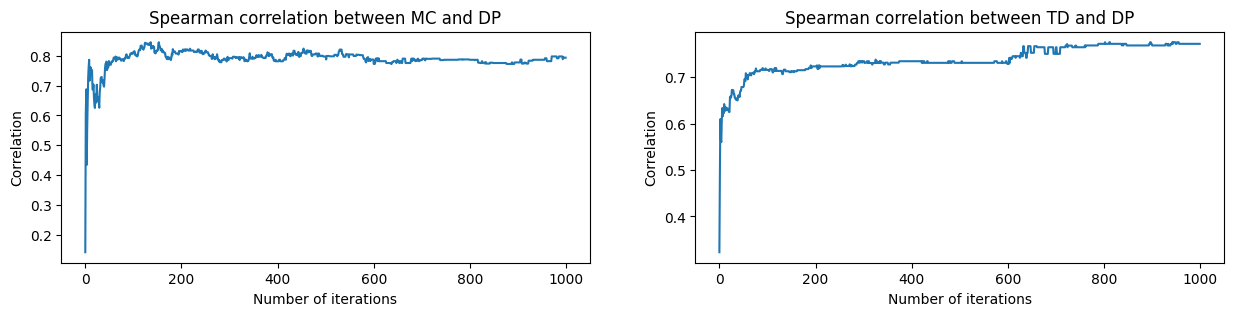

In [115]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

corr_MC_DP = []
for i in range(n_episodes):
    correlation, p_value = spearmanr(valuelist_MC[i], valuelist_DP[i])
    corr_MC_DP.append(correlation)
    
corr_TD_DP = []
for i in range(n_episodes):
    correlation, p_value = spearmanr(valuelist_TD[i], valuelist_DP[i])
    corr_TD_DP.append(correlation)

plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
plt.title('Spearman correlation between MC and DP')
plt.plot(corr_MC_DP)
plt.xlabel('Number of iterations')
plt.ylabel('Correlation')

plt.subplot(1, 2, 2)
plt.title('Spearman correlation between TD and DP')
plt.plot(corr_TD_DP)
plt.xlabel('Number of iterations')
plt.ylabel('Correlation')

plt.show()

## To do

Test the other environments:
* The maze: can you find the exit after policy improvement?<br> You might adapt the number of episodes used for training.
* The games (Tic-Tac-Toe, Nim, Connect Four): can you beat a random player after policy improvement? a player with the one-step policy?<br> Comment the results.

## Maze

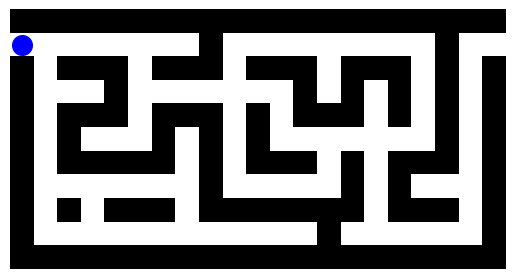

In [116]:
maze_map = np.load('maze.npy')
init_state = (1, 0)
exit_state = (1, 20)
Maze.set_parameters(maze_map, init_state, [exit_state])
maze = Maze()
maze.display()

The code block below will take around 2 min to complete.

In [ ]:
algo = MCLearning(maze, policy='random')
n_episodes = 1000
for t in range(n_episodes):
    algo.update_values(state='random', horizon=5000)

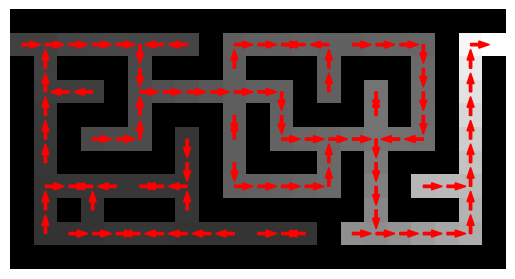

In [146]:
values = algo.get_values()
policy = algo.get_policy()
maze.display_policy(policy)
maze.display_values(values)

We can observe that MC can find the exit.

## Games

---
#### Tictactoe: Random

In [178]:
game = TicTacToe(adversary_policy='random')

In [179]:
algo = MCLearning(game, policy='random')
n_episodes = 250
for t in range(n_episodes):
    algo.update_values(state='random')
policy = algo.get_policy()

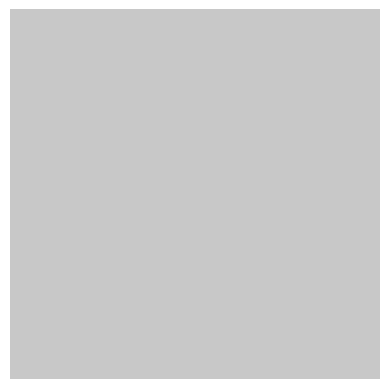

In [180]:
agent = Agent(game, policy)
stop, states, rewards = agent.get_episode()
animation = game.display(states)

In [181]:
animation

In [182]:
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

0.655

After $250$ episodes, we have a gain of $0.655$ (it may vary), which means that we are likely to win against a player with random strategy.

#### Tictactoe: One-step

In [183]:
game = TicTacToe(adversary_policy='one_step')

In [184]:
algo = MCLearning(game, policy='random')
n_episodes = 250
for t in range(n_episodes):
    algo.update_values(state='random')
policy = algo.get_policy()

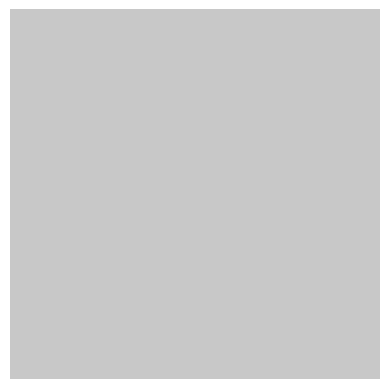

In [185]:
agent = Agent(game, policy)
stop, states, rewards = agent.get_episode()
animation = game.display(states)

In [186]:
animation

In [187]:
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

-0.478

After $250$ episodes, we have a gain of $-0.478$ (it may vary), which means that we are likely to lose against a player with one-step strategy. It's because that the states encountered with our learnt episode is small with regard to the total number of states (which equals to $\sum_{i=1}^{9} A(9,i)$).

---
#### Nim: Random

In [188]:
game = Nim(adversary_policy='random')

In [189]:
algo = MCLearning(game, policy='random')
n_episodes = 5000
for t in range(n_episodes):
    algo.update_values(state='random')
policy = algo.get_policy()

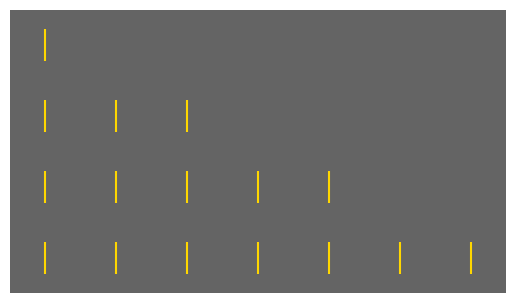

In [190]:
agent = Agent(game, policy)
stop, states, rewards = agent.get_episode()
animation = game.display(states)

In [191]:
animation

In [192]:
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

0.79

After $5000$ episodes, we have a gain of $0.79$ (it may vary), which means that we are likely to win against a player with random strategy.

#### Nim: One-step

In [193]:
game = Nim(adversary_policy='one_step')

In [194]:
algo = MCLearning(game, policy='random')
n_episodes = 5000
for t in range(n_episodes):
    algo.update_values(state='random')
policy = algo.get_policy()

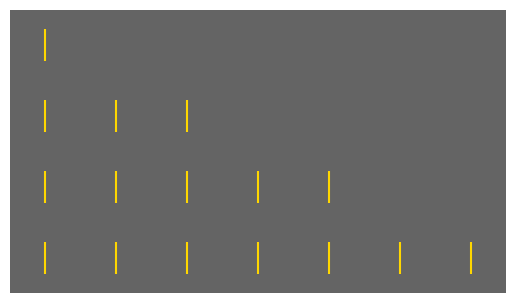

In [195]:
agent = Agent(game, policy)
stop, states, rewards = agent.get_episode()
animation = game.display(states)

In [196]:
animation

In [197]:
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

0.79

After $5000$ episodes, we have a gain of $0.79$ (it may vary), which means that we are likely to win against a player with one-step strategy. The total number of states equals to $2\times 4\times 6\times 8\times 2=768$, which is much smaller than the states which we encountered in $5000$ episodes.

---
#### Connect Four

In [198]:
game = ConnectFour(adversary_policy='random')

In [199]:
algo = MCLearning(game, policy='random')
n_episodes = 10
for t in range(n_episodes):
    algo.update_values(state='random')
policy = algo.get_policy()

ValueError: Cannot set a random state. The state space is too large.

It seems that we cannot use this method to deal with Connect Four.